# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,plot_roc_curve,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing,metrics 
from pandas import DataFrame
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing,metrics 

# Loading the Data and Selecting the Features

### Import Data

In [2]:
loan_data = pd.read_csv('loan_data_clean.csv', index_col = 0)
loan_data.drop(['issue_d','loan_status'], axis = 1, inplace = True)

In [3]:
loan_data.head()

,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,...,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,5000,5000,36,10.65,162.87,10,24000.0,27.65,3.0,0.0,...,0,0,0,0,0,0,0,1,0,1
1,2500,2500,60,15.27,59.83,0,30000.0,1.00,3.0,0.0,...,0,0,0,0,0,0,0,1,1,0
2,2400,2400,36,15.96,84.33,10,12252.0,8.72,2.0,0.0,...,1,0,0,0,0,0,0,1,0,0
3,10000,10000,36,13.49,339.31,10,49200.0,20.00,10.0,0.0,...,0,0,0,0,0,0,0,1,1,0
4,3000,3000,60,12.69,67.79,1,80000.0,17.94,15.0,0.0,...,0,0,0,0,0,0,0,1,1,0


### Handling for class Imbalance (SMOTE)

In the previous workbook, we have seen that there was a slight class imbalance in the number of good loans to bad loans with a ratio of 1:8. We conduct oversampling on the minority class using SMOTE.

In [4]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'])

#Checks class representation
pd.Series(y_resampled).value_counts()

0    395946
1    395946
Name: good_bad, dtype: int64

In [5]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [6]:
loan_data_inputs_train.head()

,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,...,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
15139,15250,15250,60,20.250000,406.160000,3,45000.000000,24.100000,13.000000,0.0,...,0,0,0,0,0,0,1,0,0,0
105234,28000,28000,36,18.250000,1015.790000,1,80000.000000,29.870000,9.000000,0.0,...,0,0,0,0,0,0,1,0,0,1
226583,20000,20000,36,13.660000,680.260000,2,70000.000000,18.820000,22.000000,0.0,...,0,0,0,1,0,0,0,0,0,1
313380,25000,25000,36,9.170000,796.980000,0,67000.000000,12.380000,13.000000,0.0,...,0,0,0,0,0,0,0,1,1,0
673627,13149,13149,36,14.458289,452.345842,9,31373.669437,12.213308,10.982256,0.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
loan_data_targets_train.head()

15139     1
105234    0
226583    1
313380    1
673627    0
Name: good_bad, dtype: int64

# PD Model Estimation

We have chosen logistic regression as our benchmark in our scope today as we are working with a binary independent variable in our dataset. Logistic regression is a powerful model that uses a logit function which is basic and also good for intepretability. After which, we will be looking at using random forest as it is recommended by research papers for having the highest accuracy.

We have chosen subsequently chosen balanced bagging mmethod as it works well with a highly imbalanced dataset where we noted above that the proportion of good loans far outstrips our bad loans. Therefore, in order to handle this, we will discuss this element later in the section. Noted that there are other ensemble methods with different techniques to handle class imbalance such as SMOTE,however we will explore them in detail in future.

source: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
        https://www.moodysanalytics.com/risk-perspectives-magazine/managing-disruption/spotlight/machine-learning-challenges-lessons-and-opportunities-in-credit-risk-modeling

## Logistic Regression

In [8]:
from sklearn.model_selection import GridSearchCV
def log_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=5)
    grid.fit(loan_data_inputs_train, loan_data_targets_train.values.ravel())
    return grid.best_score_,grid.best_estimator_
reg = LogisticRegression()
param_grid ={"C":np.logspace(-3,3,7)}
Best_Accuracy, Best_classifier = log_validation_best_parameters(reg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)
# We create an instance of an object from the 'LogisticRegression' class.

Best accuracy is 0.8744161508439877
LogisticRegression(C=0.001)


In [9]:
best_class_LR =LogisticRegression(C=Best_classifier.C)
best_class_LR.fit(loan_data_inputs_train, loan_data_targets_train.values.ravel())

LogisticRegression(C=0.001)

In [10]:
yy_pred = best_class_LR.predict(loan_data_inputs_test)

In [11]:
print('F1 Score: %.3f' % f1_score(loan_data_targets_test,yy_pred ))

F1 Score: 0.875


In [12]:
feature_name = loan_data_inputs_train.columns.values
# Stores the names of the columns of a dataframe in a variable.

In [13]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(best_class_LR.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', best_class_LR.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
summary_table.head(21)

,Feature name,Coefficients
0,Intercept,0.000112
1,loan_amnt,-0.000107
2,funded_amnt,0.000295
3,term,0.003296
4,int_rate,-0.000879
5,installment,-0.014444
6,emp_length,0.002285
7,annual_inc,0.000015
8,dti,0.002976
9,open_acc,0.000369


# PD Model Validation (Test)

In [14]:
best_class_LR = LogisticRegression(C=Best_classifier.C)
best_class_LR.fit(loan_data_inputs_train, loan_data_targets_train.values.ravel())
LR_Predict = best_class_LR.predict_proba(loan_data_inputs_test)[:,1]
LR_Predict_bin = best_class_LR.predict(loan_data_inputs_test)
LR_Accuracy = accuracy_score(loan_data_targets_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)







Logistic regression accuracy is  0.8740805283528751


In [15]:
df_actual_predicted_probs = pd.concat([pd.DataFrame(LR_Predict_bin), pd.DataFrame(LR_Predict)], axis = 1)
#threshold=0.9
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
#df_actual_predicted_probs['loan_data_targets_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > threshold, 1, 0)
#df_actual_predicted_probs.index = loan_data_inputs_test.index
df_actual_predicted_probs.head()


,loan_data_targets_test,y_hat_test_proba
0,1,9.999991e-01
1,1,7.596211e-01
2,0,1.571369e-56
3,0,0.000000e+00
4,1,5.219396e-01


<Figure size 432x432 with 0 Axes>

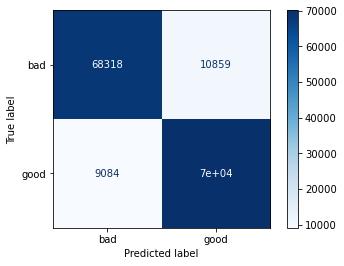

In [16]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(best_class_LR, loan_data_inputs_test,loan_data_targets_test, cmap='Blues',
                       display_labels=['bad', 'good']);
plt.show()

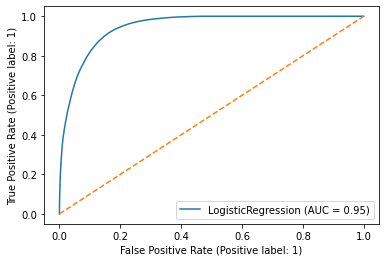

In [17]:
plot_roc_curve(best_class_LR,loan_data_inputs_test,loan_data_targets_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')
plt.show()

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf = RandomForestClassifier(random_state=42)

In [20]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(loan_data_inputs_train,loan_data_targets_train)
print(gs.best_score_)
gs.best_params_

0.9800130380548495


{'max_depth': None, 'n_estimators': 150}

In [21]:
gs.score(loan_data_inputs_test,loan_data_targets_test)

0.9805529773517954

In [22]:
y_pred = gs.predict(loan_data_inputs_test)

In [23]:
print('F1 Score: %.3f' % f1_score(loan_data_targets_test,y_pred ))

F1 Score: 0.981


In [24]:
feature_importances = pd.DataFrame(gs.best_estimator_.feature_importances_,
                                   index = loan_data_inputs_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [25]:
print("Features sorted by their score: Top 20")
feature_importances.iloc[2: , :].head(22)# filtered our recoveries and recovered pricnicpal as they are post loan approval fields

Features sorted by their score: Top 20


,importance
int_rate,0.065965
mths_since_issue_d,0.050540
installment,0.032672
grade_B,0.032596
grade_C,0.027842
home_ownership_MORTGAGE,0.027508
funded_amnt,0.026979
loan_amnt,0.025267
home_ownership_RENT,0.025223
purpose_credit_card,0.021670


<Figure size 432x432 with 0 Axes>

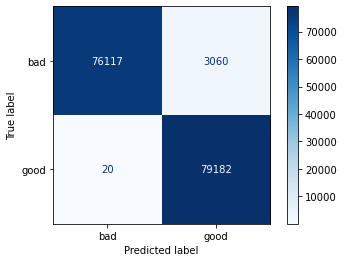

In [26]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(gs, loan_data_inputs_test,loan_data_targets_test, cmap='Blues',
                       display_labels=['bad', 'good']);
plt.show()

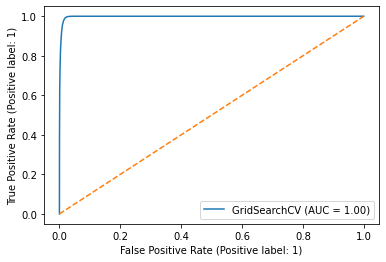

In [27]:
plot_roc_curve(gs,loan_data_inputs_test,loan_data_targets_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')
plt.show()

### Balanced bagging classifier

BalancedBaggingClassifier is a version of bagging that uses a random undersampling strategy on the majority class within a bootstrap sample in order to balance the two classes. Next, we can evaluate a modified version of the bagged decision tree ensemble that performs random undersampling of the majority class prior to fitting each decision tree.



In [28]:
# bagged decision trees with random undersampling for imbalanced classification
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier

# define model
model = BalancedBaggingClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, loan_data_inputs_train,loan_data_targets_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.999


In [29]:
score_test = cross_val_score(model, loan_data_inputs_test,loan_data_targets_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(score_test))

Mean ROC AUC: 0.997


Out of the few models we have seen to model pD, we can see that balancedbagging classifier that has the highest score of 0.99 for both the training set and testing set. This shows no overfit and the scores are significantly higher than that of logistic regression. This model would be the best model to use to predict probability of default(chance of individual defaulting on loan/bad loan) 

It works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. 

Our top 3 features in defining probability of default would indeed be interest rate, months since lasst issue date and installment. Other useful factors would include term, loan grade and loan amount
